### Instruction for running the code:
- This code requires T4 GPU to run. It uses a library that allow random forest regression model to run on GPU.
- High RAM is recommeneded.

### Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Make imports

In [2]:
!pip install implicit
import implicit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sparse
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

!pip install scikit-surprise
from surprise import Reader, Dataset, SVD, KNNBasic, KNNWithZScore, KNNWithMeans, KNNBaseline, CoClustering, SlopeOne
from surprise.model_selection import cross_validate, train_test_split
from surprise import NMF

import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import product

pd.options.mode.copy_on_write = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357227 sha256=27c39aff783963ab9a8a3452c5558d433f14781f954285d8a4afd81e40f1138a
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


This part installs the library RAPIDS which allow models to run on GPU. Random forest regressor model from sklearn only runs on CPU. This takes a long time when doing hyperparameter tuning. So, I decided to use this library instead. I have the code that does hyperparameter tuning for RF and this saves a lot of time.

Please refer to this link for more info: https://colab.research.google.com/drive/13sspqiEZwso4NYTbsflpPyNFaVAAxUgr and https://www.kaggle.com/code/jonaspalucibarbosa/30days-random-forest-on-gpu-rapids

The following command should install the library in less than 5 minutes. The successful installation should show the current output.


In [3]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 481, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 481 (delta 143), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (481/481), 133.58 KiB | 970.00 KiB/s, done.
Resolving deltas: 100% (245/245), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a Tesla T4 GPU!
We will install the latest stable RAPIDS via pip 24.4.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 MB 12

Make the import for the cuML library from RAPIDS.

In [4]:
import cuml
from cuml.ensemble import RandomForestRegressor

### Data exploration

Load the datasets

In [5]:
train_df = pd.read_csv('/train.csv')
test_df = pd.read_csv('/test.csv')

Let's look at the data

In [6]:
train_df.head()

,user_id,product_id,product_name,rating,votes,helpful_votes,ID
0,1813,154533,Beautiful Thing,5,10,8,0
1,1944,192838,Almost Famous,5,4,2,1
2,534,202590,A Clockwork Orange,5,5,5,2
3,1811,140456,Great Expectations (Wordsworth Classics),4,1,0,3
4,102,154278,Phenomenon,5,0,0,4


In [7]:
test_df.head()

,ID,user_id,product_id,product_name
0,0,1916,185507,Maria [Australia]
1,1,1759,143430,"The Mitchells: Five for Victory (Van Stockum, ..."
2,2,1980,155861,Superman Cartoons of Max & Dav
3,3,1502,71535,The Rainbow Fish Anniversary Edition
4,4,1255,13521,Confessions (Oxford World's Classics)


look at the dimension

In [8]:
print(train_df.shape, test_df.shape)

(745889, 7) (223553, 4)


What are the number of products that only appear in test data?

In [9]:
# Get the unique product IDs from test_df and train_df
test_product_ids = set(test_df['product_id'].unique())
train_product_ids = set(train_df['product_id'].unique())

# Find the product IDs that appear in test_df but not in train_df
unique_test_product_ids = test_product_ids - train_product_ids

# Get the count of product IDs that appear only in test_df
unique_test_product_count = len(unique_test_product_ids)

# Print the count
print("Number of product IDs that appear only in test_df:", unique_test_product_count)


Number of product IDs that appear only in test_df: 18534


In [10]:
# Get the unique product IDs from test_df and train_df
test_product_ids = set(test_df['product_id'].unique())
train_product_ids = set(train_df['product_id'].unique())

# Find the union of the sets
total_product_ids = test_product_ids.union(train_product_ids)

# Get the total count of unique product IDs
total_product_count = len(total_product_ids)

# Print the count
print("Total number of unique product IDs:", total_product_count)


Total number of unique product IDs: 219859


### The solution

This is an overview of what the solution does

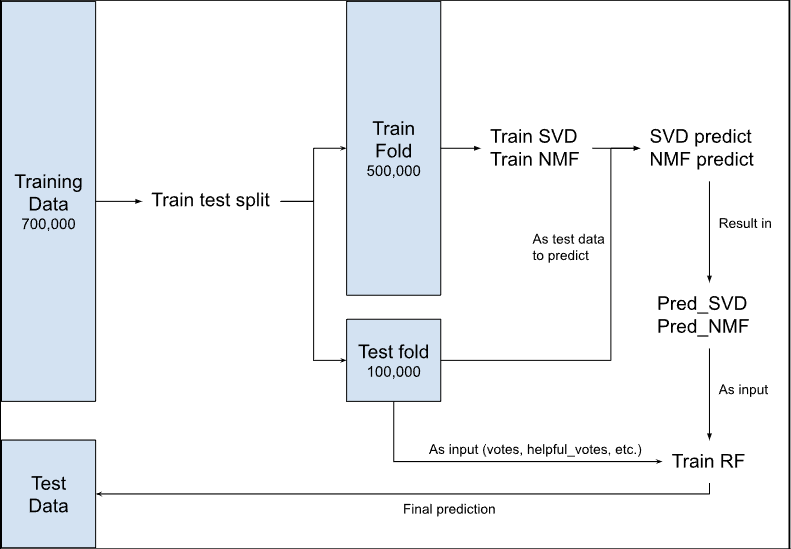

Set seed for deterministic result

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# set seed
seed = 44
random.seed(seed)
np.random.seed(seed)

Load datasets and prepare data to be used later

In [18]:
# load daatsets
train_data = pd.read_csv('/train.csv')
test_data = pd.read_csv('/test.csv')

# aggregate data to be used later
unique_product_ids = set(train_data['product_id'].unique())
avg_rating = train_data.groupby('user_id')['rating'].mean().to_dict()
user_rate_count = train_data.groupby('user_id').size()

rating_counts = [{} for _ in range(5)]
for rating in range(1, 6):
    filtered_data = train_data[train_data['rating'] == rating]
    user_rating_counts = filtered_data['user_id'].value_counts().to_dict()
    rating_counts[rating - 1] = user_rating_counts

Create array to store data

In [19]:
# prepare arrays to store data
all_res = pd.DataFrame(columns=['actual_rating'], index=range(len(train_data)))
all_res['actual_rating'] = train_data['rating']
SVD_preds = [None] * len(train_data)
NMF_preds = [None] * len(train_data)
KNN_preds = [None] * len(train_data)
CoCl_preds = [None] * len(train_data)
avg_preds = [None] * len(train_data)
avg_user_rating = [None] * len(train_data)
min_user_rating = [None] * len(train_data)
max_user_rating = [None] * len(train_data)
total_user_vote = [None] * len(train_data)
total_user_hvote = [None] * len(train_data)
total_user_rate_count = [None] * len(train_data)
total_user_rate1 = [None] * len(train_data)
total_user_rate2 = [None] * len(train_data)
total_user_rate3 = [None] * len(train_data)
total_user_rate4 = [None] * len(train_data)
total_user_rate5 = [None] * len(train_data)

This is where a lot of things happen. Here is a quick overview:
- This whole cell is a cross validation process (to get the predictions of the models)
- For each fold, the model SVD, NMK, KNN and CoClustering are trained and used to predict the test fold.
- Also, for each fold, collect data related to the test fold (e.g. average user rating) to be used as the features to the RF model later.
- After all fold, we would have had the predictions and other features for all the rows in the train set.

In [20]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# for each fold
for fold, (train_index, val_index) in enumerate(kf.split(train_data)):
    print(f"Fold {fold+1}")

    # split data
    train_fold = train_data.iloc[train_index]
    val_fold = train_data.iloc[val_index]

    # aggregate data to easily refer to
    u_avg_rating = train_fold.groupby('user_id')['rating'].mean().to_dict()
    u_min_rating = train_fold.groupby('user_id')['rating'].min().to_dict()
    u_max_rating = train_fold.groupby('user_id')['rating'].max().to_dict()
    u_total_vote = train_fold.groupby('user_id')['votes'].sum().to_dict()
    u_total_hvote = train_fold.groupby('user_id')['helpful_votes'].sum().to_dict()
    u_rate_count = train_fold.groupby('user_id').size()

    u_rating_counts = [{} for _ in range(5)]
    for rating in range(1, 6):
        filtered_data = train_fold[train_fold['rating'] == rating]
        user_rating_counts = filtered_data['user_id'].value_counts().to_dict()
        u_rating_counts[rating - 1] = user_rating_counts


    # TRAIN MODELS AND MAKE PREDICTIONS-----------------------------------------

    # train SVD
    train_subset = train_fold.copy()
    reader = Reader()
    train_subset = Dataset.load_from_df(train_subset[['user_id', 'product_id', 'rating']], reader)
    train_subset = train_subset.build_full_trainset()
    algo_SVD = SVD(n_factors=150, n_epochs=200, lr_all=0.02, reg_all=0.06, random_state=seed)
    algo_SVD.fit(train_subset)

    # predict using SVD (while looping through the test fold, also collect other features)
    for index, row in tqdm(val_fold.iterrows(), total=len(val_fold), desc="Predicting ratings using SVD"):
        userId = row['user_id']
        prodId = row['product_id']
        rowId = row['ID']

        # Predict rating using the trained SVD algorithm
        predicted_rating = algo_SVD.predict(userId, prodId).est
        SVD_preds[rowId] = predicted_rating

        # collect other features
        avg_user_rating[rowId] = u_avg_rating.get(userId)
        min_user_rating[rowId] = u_min_rating.get(userId)
        max_user_rating[rowId] = u_max_rating.get(userId)
        total_user_vote[rowId] = u_total_vote.get(userId)
        total_user_hvote[rowId] = u_total_hvote.get(userId)
        total_user_rate_count[rowId] = u_rate_count.get(userId)
        total_user_rate1[rowId] = u_rating_counts[0].get(userId) if u_rating_counts[0].get(userId) is not None else 0
        total_user_rate2[rowId] = u_rating_counts[1].get(userId) if u_rating_counts[1].get(userId) is not None else 0
        total_user_rate3[rowId] = u_rating_counts[2].get(userId) if u_rating_counts[2].get(userId) is not None else 0
        total_user_rate4[rowId] = u_rating_counts[3].get(userId) if u_rating_counts[3].get(userId) is not None else 0
        total_user_rate5[rowId] = u_rating_counts[4].get(userId) if u_rating_counts[4].get(userId) is not None else 0


    # train NMF
    train_subset = train_fold.copy()
    train_subset = Dataset.load_from_df(train_subset[['user_id', 'product_id', 'rating']], reader)
    train_subset = train_subset.build_full_trainset()
    algo_NMF = NMF(n_factors=20, n_epochs=30, reg_pu=0.06, reg_qi=0.06, random_state=seed)
    algo_NMF.fit(train_subset)

    # predict using NMF
    for index, row in tqdm(val_fold.iterrows(), total=len(val_fold), desc="Predicting ratings using NMF"):
        userId = row['user_id']
        prodId = row['product_id']
        rowId = row['ID']

        # Predict rating using the trained NMF algorithm
        predicted_rating = algo_NMF.predict(userId, prodId).est
        NMF_preds[rowId] = predicted_rating


    # train KNN
    train_subset = train_fold.copy()
    train_subset = Dataset.load_from_df(train_subset[['user_id', 'product_id', 'rating']], reader)
    train_subset = train_subset.build_full_trainset()
    algo_KNN = KNNBasic(random_state=seed)
    algo_KNN.fit(train_subset)

    # predict using KNN
    for index, row in tqdm(val_fold.iterrows(), total=len(val_fold), desc="Predicting ratings using KNN"):
        userId = row['user_id']
        prodId = row['product_id']
        rowId = row['ID']

        # Predict rating using the trained NMF algorithm
        predicted_rating = algo_KNN.predict(userId, prodId).est
        KNN_preds[rowId] = predicted_rating


    # train CoClustering
    train_subset = train_fold.copy()
    train_subset = Dataset.load_from_df(train_subset[['user_id', 'product_id', 'rating']], reader)
    train_subset = train_subset.build_full_trainset()
    algo_CoCl = CoClustering(random_state=seed)
    algo_CoCl.fit(train_subset)

    # predict using CoClustering
    for index, row in tqdm(val_fold.iterrows(), total=len(val_fold), desc="Predicting ratings using CoClustering"):
        userId = row['user_id']
        prodId = row['product_id']
        rowId = row['ID']

        # Predict rating using the trained NMF algorithm
        predicted_rating = algo_CoCl.predict(userId, prodId).est
        CoCl_preds[rowId] = predicted_rating

# average prediction (another feature)
avg_preds = (np.array(SVD_preds) + np.array(NMF_preds) + np.array(KNN_preds) + np.array(CoCl_preds)) / 4


Fold 1


Predicting ratings using NMF: 100%|██████████| 149178/149178 [00:11<00:00, 13268.33it/s]


Computing the msd similarity matrix...
Done computing similarity matrix.


Predicting ratings using CoClustering: 100%|██████████| 149178/149178 [00:10<00:00, 14839.22it/s]


Fold 2


Predicting ratings using NMF: 100%|██████████| 149178/149178 [00:11<00:00, 13013.66it/s]


Computing the msd similarity matrix...
Done computing similarity matrix.


Predicting ratings using CoClustering: 100%|██████████| 149178/149178 [00:09<00:00, 15229.36it/s]


Fold 3


Predicting ratings using NMF: 100%|██████████| 149178/149178 [00:11<00:00, 12665.01it/s]


Computing the msd similarity matrix...
Done computing similarity matrix.


Predicting ratings using CoClustering: 100%|██████████| 149178/149178 [00:09<00:00, 15210.79it/s]


Fold 4


Predicting ratings using NMF: 100%|██████████| 149178/149178 [00:11<00:00, 12506.76it/s]


Computing the msd similarity matrix...
Done computing similarity matrix.


Predicting ratings using CoClustering: 100%|██████████| 149178/149178 [00:10<00:00, 14748.00it/s]


Fold 5


Predicting ratings using NMF: 100%|██████████| 149177/149177 [00:11<00:00, 13240.91it/s]


Computing the msd similarity matrix...
Done computing similarity matrix.


Predicting ratings using CoClustering: 100%|██████████| 149177/149177 [00:09<00:00, 15268.83it/s]


Also, a lot of things happen here. Here is a quick overview:
- Load data
- Aggregate data (e.g. get average rating per user)
- Train SVD, NMF, KNN, CoClustering on full training data
- Use these models to make predictions on the test data while collecting features from test data
- Use the features collected from the previous cell to train RF.
- Use RF to predict test data based on the predictions and other features collected from test data

Please refer to the code's comment for more detail

In [21]:
from cuml.ensemble import RandomForestRegressor

# load the dataset again (just in case data was changed previously)
train_data = pd.read_csv('/train.csv')
test_data = pd.read_csv('/test.csv')

# aggregate data so it's easy to refer to later
unique_product_ids = set(train_data['product_id'].unique())
avg_rating = train_data.groupby('user_id')['rating'].mean().to_dict()
min_rating = train_data.groupby('user_id')['rating'].min().to_dict()
max_rating = train_data.groupby('user_id')['rating'].max().to_dict()
user_total_vote = train_data.groupby('user_id')['votes'].sum().to_dict()
user_total_hvote = train_data.groupby('user_id')['helpful_votes'].sum().to_dict()
user_rate_count = train_data.groupby('user_id').size()

rating_counts = [{} for _ in range(5)]
for rating in range(1, 6):
    filtered_data = train_data[train_data['rating'] == rating]
    user_rating_counts = filtered_data['user_id'].value_counts().to_dict()
    rating_counts[rating - 1] = user_rating_counts


# train all the models again. This time with the full training data, so we get the best models to make the final predictions
train_subset = train_data.copy()
reader = Reader()
train_subset = Dataset.load_from_df(train_subset[['user_id', 'product_id', 'rating']], reader)
train_subset = train_subset.build_full_trainset()

algo_SVD = SVD(n_factors=150, n_epochs=200, lr_all=0.02, reg_all=0.06, random_state=seed)
algo_SVD.fit(train_subset)

algo_NMF = NMF(n_factors=20, n_epochs=30, reg_pu=0.06, reg_qi=0.06, random_state=seed)
algo_NMF.fit(train_subset)

algo_KNN = KNNBasic(random_state=seed)
algo_KNN.fit(train_subset)

algo_CoCl = CoClustering(random_state=seed)
algo_CoCl.fit(train_subset)

# prepare arrays to store test set features data
SVD_preds_test = [None] * len(test_data)
NMF_preds_test = [None] * len(test_data)
KNN_preds_test = [None] * len(test_data)
CoCl_preds_test = [None] * len(test_data)
avg_preds_test = [None] * len(test_data)
avg_user_rating_test = [None] * len(test_data)
min_user_rating_test = [None] * len(test_data)
max_user_rating_test = [None] * len(test_data)
total_user_vote_test = [None] * len(test_data)
total_user_hvote_test = [None] * len(test_data)
total_user_rate_count_test = [None] * len(test_data)
total_user_rate1_test = [None] * len(test_data)
total_user_rate2_test = [None] * len(test_data)
total_user_rate3_test = [None] * len(test_data)
total_user_rate4_test = [None] * len(test_data)
total_user_rate5_test = [None] * len(test_data)

# MAKE PREDICTIONS ON THE FINAL TEST DATA
# for each row in the test set
for index, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Predicting ratings"):
    userId = row['user_id']
    prodId = row['product_id']
    rowId = row['ID']

    # Predict rating using the trained SVD, NMF, KNN, CoCl algorithm
    predicted_rating_svd = algo_SVD.predict(userId, prodId).est
    predicted_rating_nmf = algo_NMF.predict(userId, prodId).est
    predicted_rating_knn = algo_KNN.predict(userId, prodId).est
    predicted_rating_cocl = algo_CoCl.predict(userId, prodId).est

    # store the predictions
    SVD_preds_test[rowId] = predicted_rating_svd
    NMF_preds_test[rowId] = predicted_rating_nmf
    KNN_preds_test[rowId] = predicted_rating_knn
    CoCl_preds_test[rowId] = predicted_rating_cocl
    avg_preds_test[rowId] = (predicted_rating_svd + predicted_rating_nmf + predicted_rating_knn + predicted_rating_cocl) / 4

    # collect other features
    avg_user_rating_test[rowId] = avg_rating.get(userId)
    min_user_rating_test[rowId] = min_rating.get(userId)
    max_user_rating_test[rowId] = max_rating.get(userId)
    total_user_vote_test[rowId] = user_total_vote.get(userId)
    total_user_hvote_test[rowId] = user_total_hvote.get(userId)
    total_user_rate_count_test[rowId] = user_rate_count.get(userId)
    total_user_rate1_test[rowId] = rating_counts[0].get(userId) if u_rating_counts[0].get(userId) is not None else 0
    total_user_rate2_test[rowId] = rating_counts[1].get(userId) if u_rating_counts[1].get(userId) is not None else 0
    total_user_rate3_test[rowId] = rating_counts[2].get(userId) if u_rating_counts[2].get(userId) is not None else 0
    total_user_rate4_test[rowId] = rating_counts[3].get(userId) if u_rating_counts[3].get(userId) is not None else 0
    total_user_rate5_test[rowId] = rating_counts[4].get(userId) if u_rating_counts[4].get(userId) is not None else 0

# create a dataframe holding all the features from the training data (from the previous cell)
train_set = pd.DataFrame()
train_set['SVD_preds'] = SVD_preds
train_set['NMF_preds'] = NMF_preds
train_set['KNN_preds'] = KNN_preds
train_set['CoCl_preds'] = CoCl_preds
train_set['avg_preds'] = avg_preds
train_set['avg_user_rating'] = avg_user_rating
train_set['min_user_rating'] = min_user_rating
train_set['max_user_rating'] = max_user_rating
train_set['total_user_vote'] = total_user_vote
train_set['total_user_hvote'] = total_user_hvote
train_set['total_user_rate_count'] = total_user_rate_count
train_set['total_user_rate1'] = total_user_rate1
train_set['total_user_rate2'] = total_user_rate2
train_set['total_user_rate3'] = total_user_rate3
train_set['total_user_rate4'] = total_user_rate4
train_set['total_user_rate5'] = total_user_rate5
train_set['actual_rating'] = train_data['rating']

# create a dataframe holding all the features from the test data
val_set = pd.DataFrame()
val_set['SVD_preds'] = SVD_preds_test
val_set['NMF_preds'] = NMF_preds_test
val_set['KNN_preds'] = KNN_preds_test
val_set['CoCl_preds'] = CoCl_preds_test
val_set['avg_preds'] = avg_preds_test
val_set['avg_user_rating'] = avg_user_rating_test
val_set['min_user_rating'] = min_user_rating_test
val_set['max_user_rating'] = max_user_rating_test
val_set['total_user_vote'] = total_user_vote_test
val_set['total_user_hvote'] = total_user_hvote_test
val_set['total_user_rate1'] = total_user_rate1_test
val_set['total_user_rate2'] = total_user_rate2_test
val_set['total_user_rate3'] = total_user_rate3_test
val_set['total_user_rate4'] = total_user_rate4_test
val_set['total_user_rate5'] = total_user_rate5_test
val_set['total_user_rate_count'] = total_user_rate_count_test

# train RF on features from train data
X_train = train_set[['SVD_preds', 'NMF_preds', 'KNN_preds', 'CoCl_preds', 'avg_preds', 'avg_user_rating', 'min_user_rating', 'max_user_rating', 'total_user_vote', 'total_user_hvote', 'total_user_rate_count', 'total_user_rate1', 'total_user_rate2', 'total_user_rate3', 'total_user_rate4', 'total_user_rate5']]
y_train = train_set['actual_rating']

# features collected from the final test set
X_val = val_set[['SVD_preds', 'NMF_preds', 'KNN_preds', 'CoCl_preds', 'avg_preds', 'avg_user_rating', 'min_user_rating', 'max_user_rating', 'total_user_vote', 'total_user_hvote', 'total_user_rate_count', 'total_user_rate1', 'total_user_rate2', 'total_user_rate3', 'total_user_rate4', 'total_user_rate5']]

# change data type of the features so that random forest can run (this RF uses GPU, not CPU)
for col in X_train.select_dtypes('float64').columns:
    X_train[col] = X_train[col].astype( np.float32 )
    X_val[col] = X_val[col].astype( np.float32 )

y_train = y_train.astype( np.float32 )

for col in X_train.select_dtypes('int64').columns:
    X_train[col] = X_train[col].astype( np.float32 )
    X_val[col] = X_val[col].astype( np.float32 )


# Instantiate and fit the Random Forest model
rf = RandomForestRegressor(n_estimators=150, max_depth=10,
                            min_samples_split=2, min_samples_leaf=8,
                            random_state=seed, n_streams=1)

# fit the random forest model
rf.fit(X_train, y_train)

# Make the final prediction
y_pred = rf.predict(X_val)

Computing the msd similarity matrix...
Done computing similarity matrix.


Predicting ratings: 100%|██████████| 223553/223553 [00:32<00:00, 6937.25it/s]


Save the predictions into the csv file

In [22]:
res = pd.DataFrame({'ID': range(len(y_pred)), 'rating': y_pred})
res.to_csv('submission.csv', index=False)